In [3]:
from google.colab import files
uploaded = files.upload()


Saving Yearly.csv to Yearly.csv


In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import pmdarima as pm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
import warnings
from imblearn.over_sampling import SMOTE
from statsmodels.tsa.holtwinters import ExponentialSmoothing



warnings.filterwarnings('ignore')


# Load the dataset and clean up column names
df = pd.read_csv("Yearly.csv")
df.columns = df.columns.str.strip()

# Ensure the 'year' column is a datetime index
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Verify there are no missing values in the data
print("Missing values in data:")
print(df.isnull().sum())

# Adding interaction terms and growth rates for feature engineering
df['cpi_earnings_interaction'] = df['cpi'] * df['avg_hourly_earnings']

# Adding growth rates
for var in ['avg_unemployment_rate', 'cpi', 'total_nonfarm_employment', 'avg_hourly_earnings']:
    df[f'{var}_growth_rate'] = df[var].pct_change() * 100

# Drop NA introduced by growth rates
df.dropna(inplace=True)



Missing values in data:
avg_unemployment_rate       0
total_nonfarm_employment    0
cpi                         0
unit_labor_costs            0
labor_productivity          0
avg_hourly_earnings         0
dtype: int64


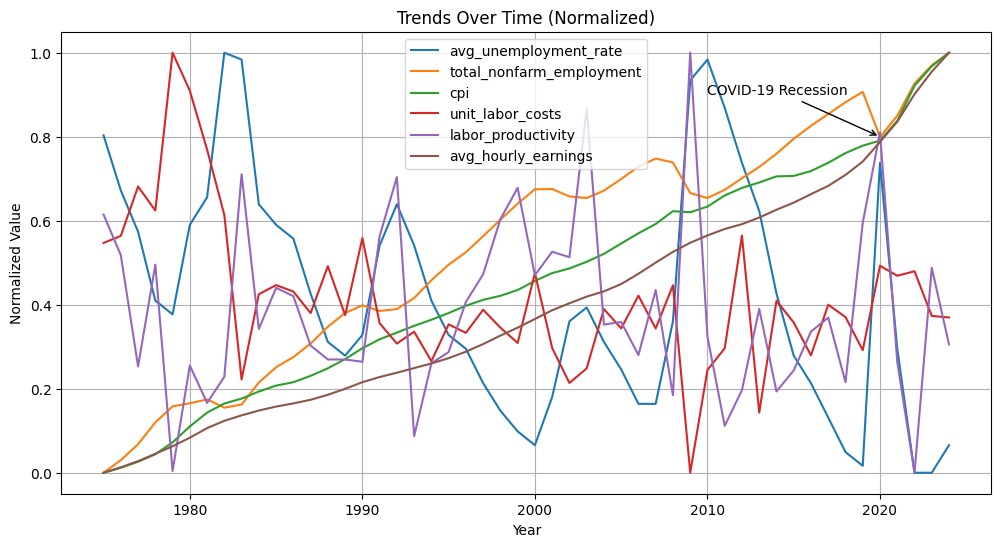

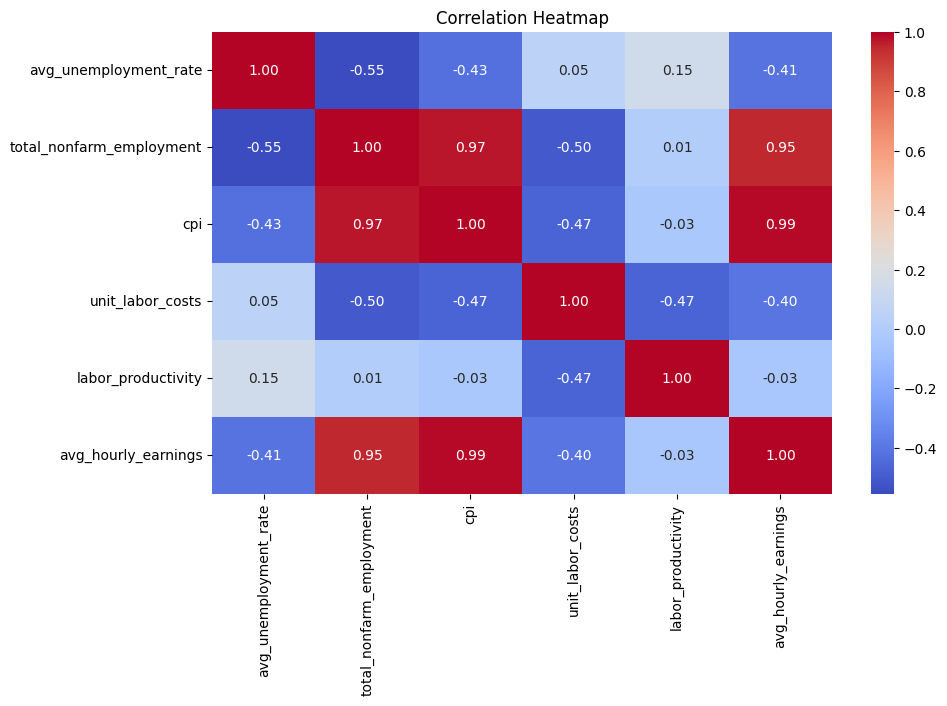

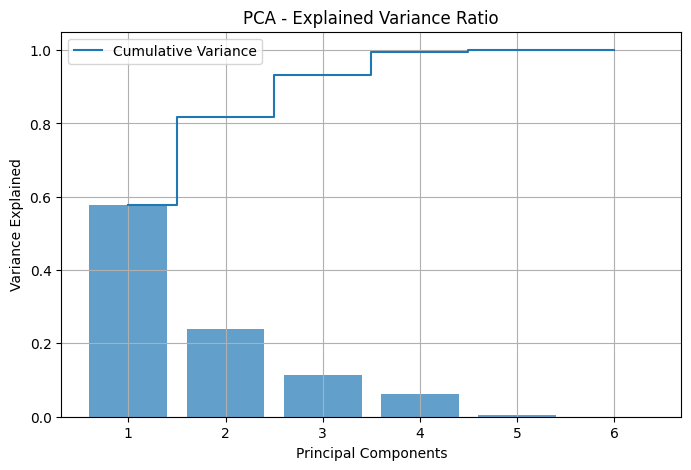

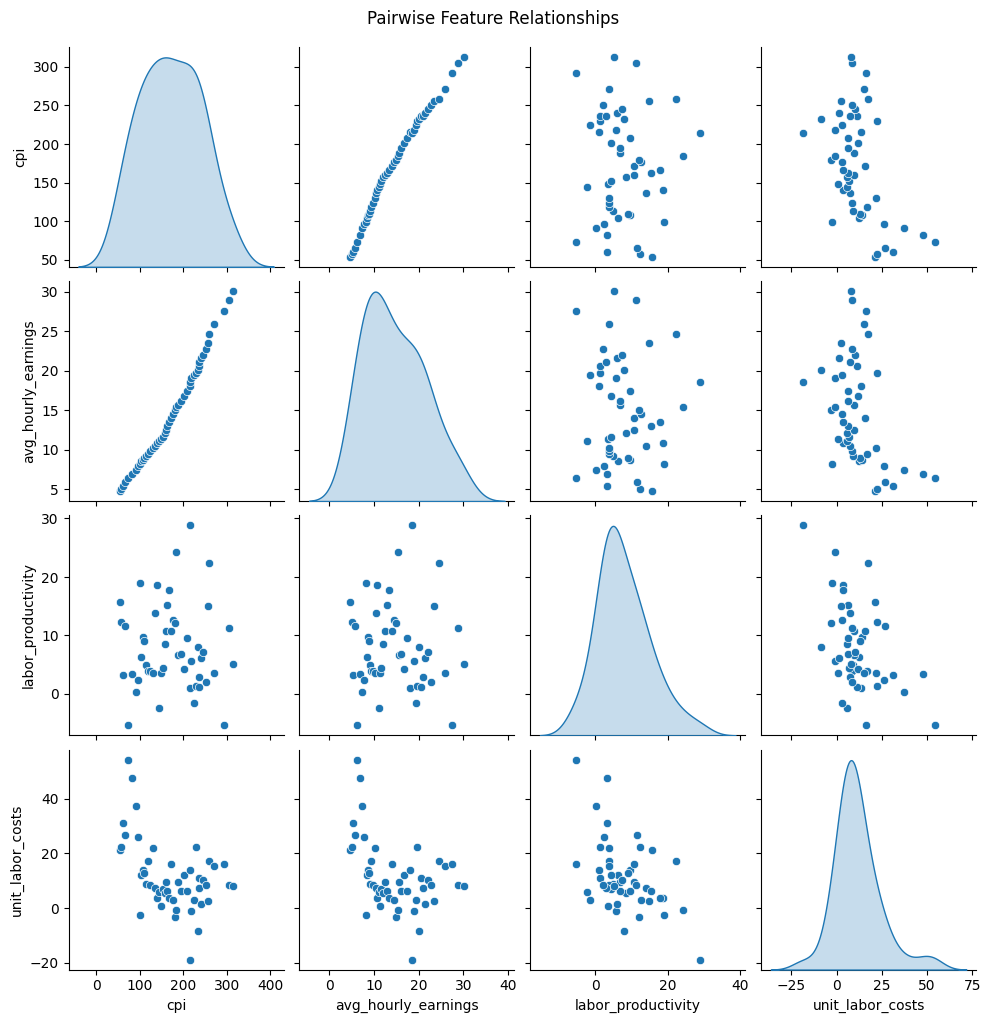

In [5]:
# EDA

# Define Variables for EDA
variables_to_plot = ['avg_unemployment_rate', 'total_nonfarm_employment', 'cpi',
                     'unit_labor_costs', 'labor_productivity', 'avg_hourly_earnings']

# Normalized Trends Visualization
normalized_df = pd.DataFrame(MinMaxScaler().fit_transform(df[variables_to_plot]),
                             columns=variables_to_plot, index=df.index)



plt.figure(figsize=(12, 6))
for var in variables_to_plot:
    plt.plot(normalized_df.index, normalized_df[var], label=var)
plt.title('Trends Over Time (Normalized)')
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Add annotations for significant events
plt.annotate("COVID-19 Recession", xy=(pd.to_datetime('2020-01-01'), 0.8), xytext=(pd.to_datetime('2010-01-01'), 0.9),
             arrowprops=dict(facecolor='red', arrowstyle="->"))
plt.show()


# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[variables_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# PCA Analysis
scaled_data = StandardScaler().fit_transform(df[variables_to_plot])
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(variables_to_plot) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.step(range(1, len(variables_to_plot) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Variance')
plt.title('PCA - Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Pairwise Scatterplots
sns.pairplot(df[['cpi', 'avg_hourly_earnings', 'labor_productivity', 'unit_labor_costs']], diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()



ADF Test for Stationarity on 'unit_labor_costs'
ADF Statistic: -3.6718400483626974
p-value: 0.004527143494252035
The series is stationary.

Linear Regression Performance:
RMSE: 7.312243696329257
R²: -0.48190195543683667


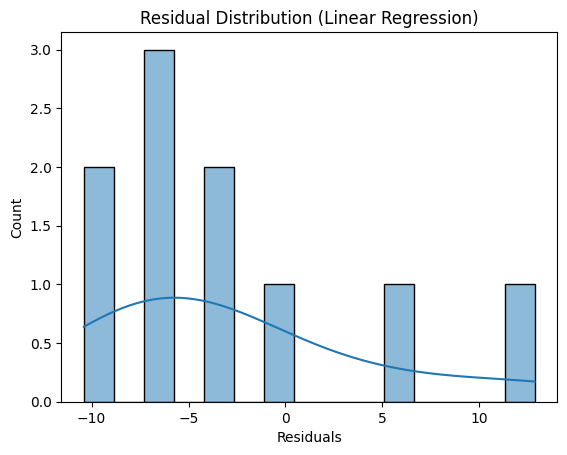


XGBoost Regression Performance:
RMSE: 6.598483964553426
R²: -0.2067199391172918


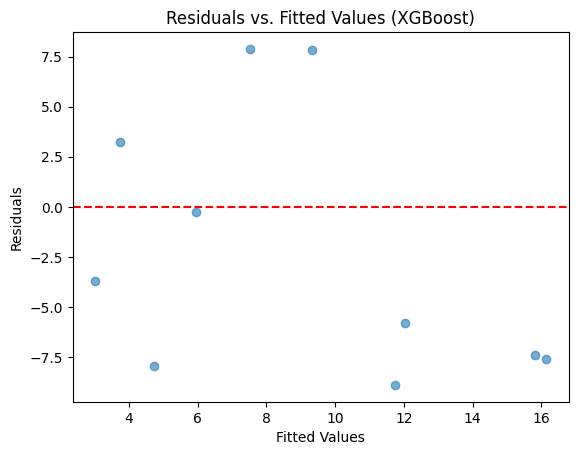


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.50      0.67         6

    accuracy                           0.70        10
   macro avg       0.79      0.75      0.70        10
weighted avg       0.83      0.70      0.69        10


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.50      0.33      0.40         6

    accuracy                           0.40        10
   macro avg       0.42      0.42      0.40        10
weighted avg       0.43      0.40      0.40        10


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       1.00      0.33      0.50         6

    accuracy                           0.60        10
   macro avg       0.75      0.67     

In [7]:
# Feature Engineering: Growth Rates
for var in variables_to_plot:
    df[f'{var}_growth_rate'] = df[var].pct_change() * 100
df.dropna(inplace=True)

# ADF Test for Stationarity
print("\nADF Test for Stationarity on 'unit_labor_costs'")
result = adfuller(df['unit_labor_costs'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("The series is NOT stationary.")
else:
    print("The series is stationary.")

# Regression Analysis

# Adding Interaction Terms
df['cpi_earnings_interaction'] = df['cpi'] * df['avg_hourly_earnings']
X = df[['avg_unemployment_rate', 'cpi', 'total_nonfarm_employment',
        'avg_hourly_earnings', 'cpi_earnings_interaction']]
y = df['unit_labor_costs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("\nLinear Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# Residual Analysis for Linear Regression
sns.histplot(y_test - y_pred, kde=True, bins=15)
plt.title('Residual Distribution (Linear Regression)')
plt.xlabel('Residuals')
plt.show()

# XGBoost Regression
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))

# Residual Analysis for XGBoost
plt.scatter(y_pred_xgb, y_test - y_pred_xgb, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values (XGBoost)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Classification

# Create Classification Target
df['labor_productivity_spike'] = (df['labor_productivity'] > df['labor_productivity'].mean()).astype(int)
y_class = df['labor_productivity_spike']

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Logistic Regression, Decision Tree, Random Forest
logreg = LogisticRegression(max_iter=500).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
dt = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)

print("\nLogistic Regression Performance:")
print(classification_report(y_test, logreg.predict(X_test)))
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf.predict(X_test)))
print("\nDecision Tree Performance:")
print(classification_report(y_test, dt.predict(X_test)))

# SMOTE for Imbalanced Classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Retrain Models on Balanced Data
logreg_sm = LogisticRegression(max_iter=500).fit(X_train_sm, y_train_sm)
rf_sm = RandomForestClassifier(n_estimators=100).fit(X_train_sm, y_train_sm)
dt_sm = DecisionTreeClassifier(max_depth=5).fit(X_train_sm, y_train_sm)

print("\nLogistic Regression with SMOTE:")
print(classification_report(y_test, logreg_sm.predict(X_test)))
print("\nRandom Forest with SMOTE:")
print(classification_report(y_test, rf_sm.predict(X_test)))
print("\nDecision Tree with SMOTE:")
print(classification_report(y_test, dt_sm.predict(X_test)))

# XGBoost Classifier
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_clf.fit(X_train_sm, y_train_sm)
print("\nXGBoost Classifier Performance:")
print(classification_report(y_test, xgb_clf.predict(X_test)))


Forecasting for 5 years ahead to capture short-term trends.
SARIMA with Exogenous Variable AIC: 270.93
XGBoost Forecasted Residuals: [  0.9907748   -1.3455299   -4.017195   -18.633759    -0.63003105]


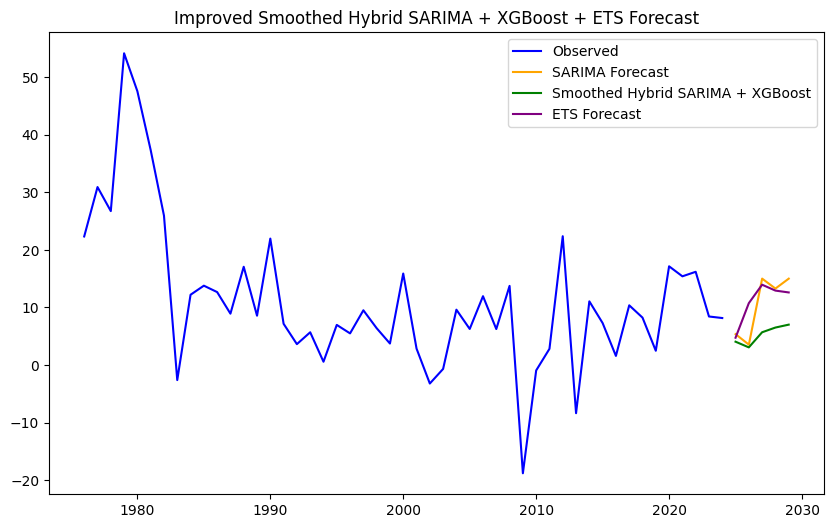

SARIMA Model RMSE: 8.39
ETS Model RMSE: 6.65
Hybrid Model RMSE: 9.38

Hybrid Forecast Output:
2024-12-31: 4.05
2025-12-31: 3.06
2026-12-31: 5.69
2027-12-31: 6.51
2028-12-31: 7.02

ETS Forecast Output:
2024-12-31: 4.74
2025-12-31: 10.75
2026-12-31: 13.96
2027-12-31: 12.94
2028-12-31: 12.61


In [9]:
# Define forecast horizon
forecast_steps = 5
print(f"Forecasting for {forecast_steps} years ahead to capture short-term trends.")

# Add exogenous variable (lagged values and moving average)
df['lagged_indicator'] = df['unit_labor_costs'].shift(1).fillna(method='bfill')
df['rolling_mean'] = df['unit_labor_costs'].rolling(window=3, min_periods=1).mean()
exog = df[['lagged_indicator', 'rolling_mean']]

# Fit SARIMA with exogenous variables
sarima_model_exog = SARIMAX(df['unit_labor_costs'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results_exog = sarima_model_exog.fit()
print(f"SARIMA with Exogenous Variable AIC: {results_exog.aic:.2f}")

# Generate SARIMA residuals
sarima_residuals = df['unit_labor_costs'] - results_exog.fittedvalues

# Prepare XGBoost data using multiple lagged residuals as features
num_lags = 3
X = np.array([sarima_residuals.shift(i).fillna(0) for i in range(1, num_lags + 1)]).T
y = sarima_residuals.values

# Train-test split
X_train, X_test = X[:-forecast_steps], X[-forecast_steps:]
y_train = y[:-forecast_steps]

# Scale XGBoost input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model on residuals
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_scaled, y_train)

# Forecast XGBoost residuals
xgb_forecast_residuals = xgb_model.predict(X_test_scaled)
print("XGBoost Forecasted Residuals:", xgb_forecast_residuals)

# Generate future exogenous values for SARIMA forecast
last_lagged = df['unit_labor_costs'].iloc[-1]
last_rolling_mean = df['unit_labor_costs'][-3:].mean()
exog_forecast = pd.DataFrame({
    'lagged_indicator': [last_lagged] * forecast_steps,
    'rolling_mean': [last_rolling_mean] * forecast_steps
}, index=pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=forecast_steps, freq='Y'))

# SARIMA forecast
sarima_forecast_exog = results_exog.get_forecast(steps=forecast_steps, exog=exog_forecast)
sarima_forecast_mean = sarima_forecast_exog.predicted_mean

# ETS Model
ets_model = ExponentialSmoothing(df['unit_labor_costs'], seasonal='add', seasonal_periods=12)
ets_results = ets_model.fit()
ets_forecast = ets_results.forecast(steps=forecast_steps)

# Combine SARIMA and XGBoost forecasts
weight_sarima = 0.7
weight_xgb = 0.3
final_hybrid_forecast = (weight_sarima * sarima_forecast_mean.values) + (weight_xgb * xgb_forecast_residuals)

# Apply smoothing
smoothed_forecast = pd.Series(final_hybrid_forecast).rolling(window=2, min_periods=1).mean()

# Visualization
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=forecast_steps, freq='Y')
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['unit_labor_costs'], label='Observed', color='blue')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='SARIMA Forecast', color='orange')
plt.plot(forecast_index, smoothed_forecast, label='Smoothed Hybrid SARIMA + XGBoost', color='green')
plt.plot(forecast_index, ets_forecast, label='ETS Forecast', color='purple')
plt.title('Improved Smoothed Hybrid SARIMA + XGBoost + ETS Forecast')
plt.legend()
plt.show()

# Calculate RMSE for All Models (requires actual values)
actual = df['unit_labor_costs'][-forecast_steps:]

rmse_sarima = np.sqrt(mean_squared_error(actual, sarima_forecast_mean))
rmse_ets = np.sqrt(mean_squared_error(actual, ets_forecast))
rmse_hybrid = np.sqrt(mean_squared_error(actual, smoothed_forecast))

print(f"SARIMA Model RMSE: {rmse_sarima:.2f}")
print(f"ETS Model RMSE: {rmse_ets:.2f}")
print(f"Hybrid Model RMSE: {rmse_hybrid:.2f}")

# Print Improved Forecast Results
print("\nHybrid Forecast Output:")
for year, value in zip(forecast_index, smoothed_forecast):
    print(f"{year.date()}: {value:.2f}")

print("\nETS Forecast Output:")
for year, value in zip(forecast_index, ets_forecast):
    print(f"{year.date()}: {value:.2f}")
